# ML Problem: Will a person suffer from human trafficking?

# 1. Libraries & Data Loading

In [1]:
import pandas as pd
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import missingno as msno
import plotly.express as px
import plotly.graph_objects as go

In [2]:
# data loading
df = pd.read_csv('Data/human_trafficking.csv')
df.head()

/var/folders/zk/vd14bsbx2679v9y9w2drl53c0000gn/T/ipykernel_97387/276243428.py:2: DtypeWarning: Columns (54) have mixed types. Specify dtype option on import or set low_memory=False.
  df = pd.read_csv('Data/human_trafficking.csv')


,yearOfRegistration,Datasource,gender,ageBroad,majorityStatus,majorityStatusAtExploit,majorityEntry,citizenship,meansOfControlDebtBondage,meansOfControlTakesEarnings,...,typeOfSexPrivateSexualServices,typeOfSexConcatenated,isAbduction,RecruiterRelationship,CountryOfExploitation,recruiterRelationIntimatePartner,recruiterRelationFriend,recruiterRelationFamily,recruiterRelationOther,recruiterRelationUnknown
0,2002,Case Management,Female,18--20,Adult,-99,-99,CO,-99,-99,...,-99,-99,-99,-99,-99,0,0,0,0,1
1,2002,Case Management,Female,18--20,Adult,-99,-99,CO,-99,-99,...,-99,-99,-99,-99,-99,0,0,0,0,1
2,2002,Case Management,Female,18--20,Adult,-99,-99,CO,-99,-99,...,-99,-99,-99,-99,-99,0,0,0,0,1
3,2002,Case Management,Female,18--20,Adult,-99,-99,CO,-99,-99,...,-99,-99,-99,-99,-99,0,0,0,0,1
4,2002,Case Management,Female,18--20,Adult,-99,-99,CO,-99,-99,...,-99,-99,-99,-99,-99,0,0,0,0,1


In [3]:
# -99 are considered mising values (NaN), so we convert them for easier handling
df.replace('-99', np.nan, inplace=True)
df.replace(-99, np.nan, inplace=True)

# 2. EDA

In [4]:
df.shape

(48801, 63)

In [5]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 48801 entries, 0 to 48800
Data columns (total 63 columns):
 #   Column                                  Non-Null Count  Dtype  
---  ------                                  --------------  -----  
 0   yearOfRegistration                      48801 non-null  int64  
 1   Datasource                              48801 non-null  object 
 2   gender                                  48801 non-null  object 
 3   ageBroad                                36439 non-null  object 
 4   majorityStatus                          36439 non-null  object 
 5   majorityStatusAtExploit                 9290 non-null   object 
 6   majorityEntry                           6491 non-null   object 
 7   citizenship                             48523 non-null  object 
 8   meansOfControlDebtBondage               2496 non-null   float64
 9   meansOfControlTakesEarnings             3997 non-null   float64
 10  meansOfControlRestrictsFinancialAccess  253 non-null    fl

In [6]:
df.isnull().sum()

yearOfRegistration                      0
Datasource                              0
gender                                  0
ageBroad                            12362
majorityStatus                      12362
                                    ...  
recruiterRelationIntimatePartner     8807
recruiterRelationFriend              8807
recruiterRelationFamily              8807
recruiterRelationOther               8807
recruiterRelationUnknown               77
Length: 63, dtype: int64

## 2.1 Feature Analysis

### 2.1.0 Time & Source Information

#### yearOfRegistration

In [7]:
print(df[['yearOfRegistration']].info())
print(df['yearOfRegistration'].describe())
print(df[['yearOfRegistration']].isnull().sum())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 48801 entries, 0 to 48800
Data columns (total 1 columns):
 #   Column              Non-Null Count  Dtype
---  ------              --------------  -----
 0   yearOfRegistration  48801 non-null  int64
dtypes: int64(1)
memory usage: 381.4 KB
None
count    48801.000000
mean      2014.144218
std          4.025566
min       2002.000000
25%       2013.000000
50%       2016.000000
75%       2017.000000
max       2019.000000
Name: yearOfRegistration, dtype: float64
yearOfRegistration    0
dtype: int64


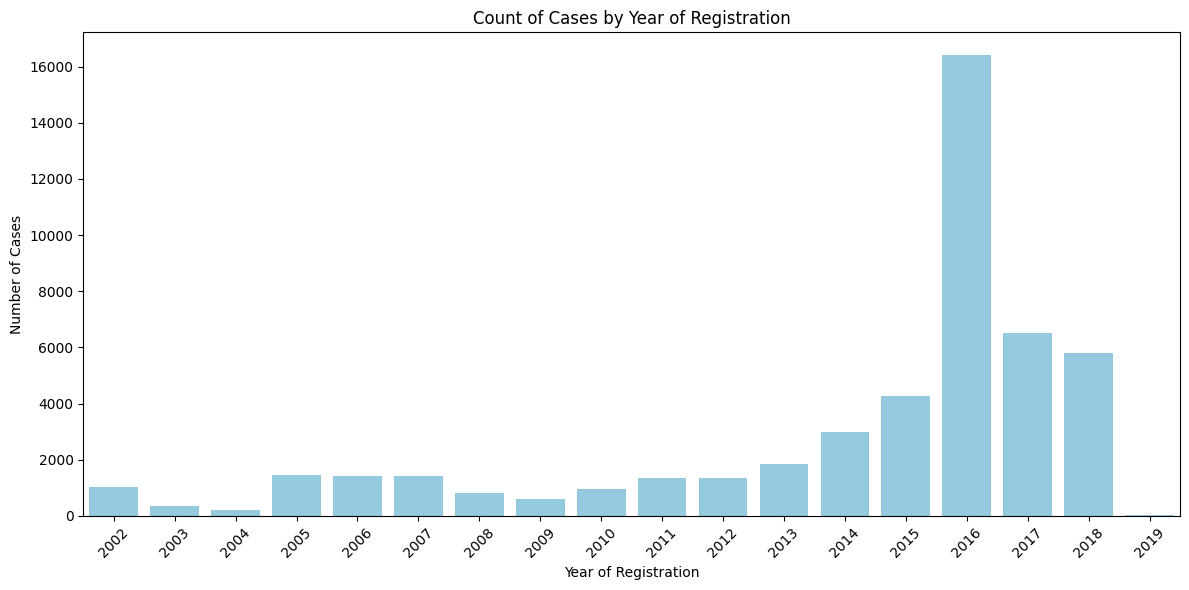

In [8]:
plt.figure(figsize=(12, 6))
sns.countplot(data=df, x='yearOfRegistration', color='skyblue') 
plt.title("Count of Cases by Year of Registration")
plt.xlabel("Year of Registration")
plt.ylabel("Number of Cases")
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

In [ ]:
# Exploitation features to visualize
exploitation_features = [
    'isForcedLabour', 'isSexualExploit', 'isOtherExploit', 'isSexAndLabour', 
    'isForcedMarriage', 'isForcedMilitary', 'isOrganRemoval', 'isSlaveryAndPractices'
]

# Melt the dataframe to long format
df_melted = df[['yearOfRegistration'] + exploitation_features].melt(id_vars='yearOfRegistration', 
                                                                     var_name='ExploitType', 
                                                                     value_name='Presence')

# Filter rows where Presence is 1 (indicating the presence of the exploit type)
df_melted = df_melted[df_melted['Presence'] == 1]

# Aggregate counts by year and exploit type
df_aggregated = df_melted.groupby(['yearOfRegistration', 'ExploitType']).size().reset_index(name='Count')

# Create an interactive Plotly bar chart
fig = px.bar(df_aggregated, 
             x="yearOfRegistration", 
             y="Count", 
             color="ExploitType", 
             barmode="stack",
             title="Trends in Exploitation Types by Year of Registration",
             labels={"yearOfRegistration": "Year of Registration", "Count": "Number of Cases"},
             height=600)

# Update layout for better readability
fig.update_layout(
    xaxis_title="Year of Registration",
    yaxis_title="Number of Cases",
    xaxis=dict(tickangle=45),
    barmode='stack',  # Stack bars to show the trend for each type of exploitation
)

# Show the plot
fig.show()



In [32]:

# List of recruiter columns
recruiter_cols = [
    'recruiterRelationIntimatePartner', 'recruiterRelationFriend', 
    'recruiterRelationFamily', 'recruiterRelationOther', 'recruiterRelationUnknown'
]

# Group by yearOfRegistration and calculate the mean for each recruiter type
recruiter_trends = df.groupby('yearOfRegistration')[recruiter_cols].mean().reset_index()

# Create an interactive line plot using Plotly
fig = px.line(recruiter_trends, 
              x='yearOfRegistration', 
              y=recruiter_cols, 
              title="Trends in Recruiter Relationship Over Time",
              labels={"yearOfRegistration": "Year of Registration", "value": "Proportion of Cases"},
              line_shape='linear',  # Linear line connection
              markers=True,         # Show markers for each point
              height=600)

# Update layout for better aesthetics and readability
fig.update_layout(
    xaxis_title="Year of Registration",
    yaxis_title="Proportion of Cases",
    xaxis=dict(tickangle=45),
    legend_title="Recruiter Relationship",
    legend=dict(title="Recruiter Relationship", x=1, y=1)
)

# Show the plot
fig.show()


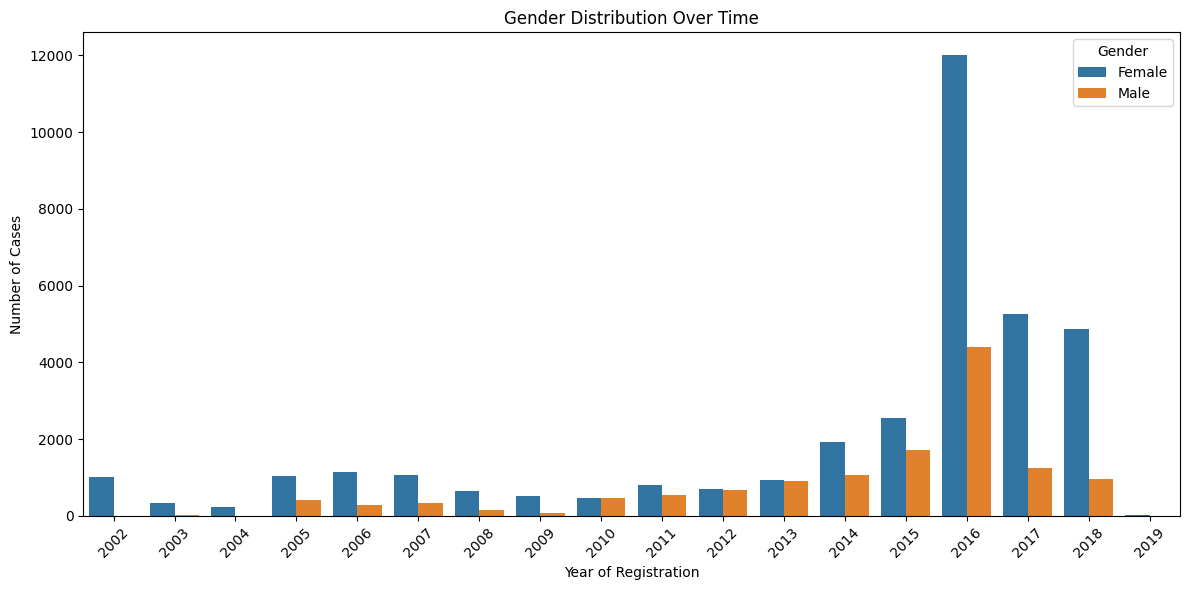

In [11]:
plt.figure(figsize=(12, 6))
sns.countplot(data=df, x='yearOfRegistration', hue='gender')
plt.title("Gender Distribution Over Time")
plt.xlabel("Year of Registration")
plt.ylabel("Number of Cases")
plt.xticks(rotation=45)
plt.legend(title="Gender")
plt.tight_layout()
plt.show()

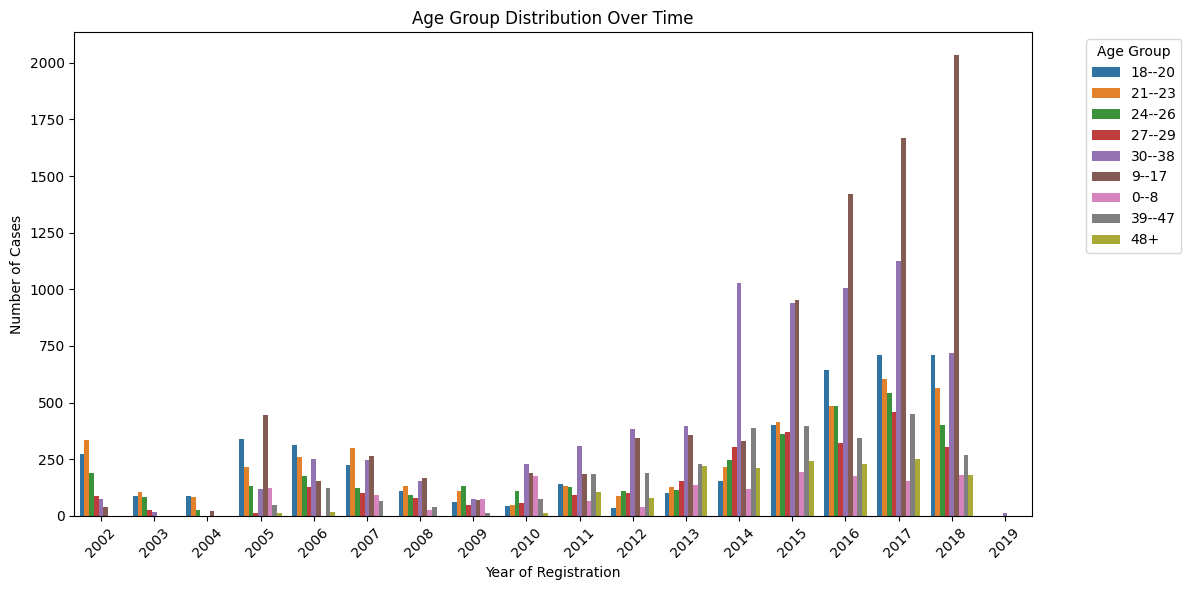

In [12]:
plt.figure(figsize=(12, 6))
sns.countplot(data=df.dropna(subset=['ageBroad']), x='yearOfRegistration', hue='ageBroad')
plt.title("Age Group Distribution Over Time")
plt.xlabel("Year of Registration")
plt.ylabel("Number of Cases")
plt.xticks(rotation=45)
plt.legend(title="Age Group", bbox_to_anchor=(1.05, 1), loc='upper left')
plt.tight_layout()
plt.show()


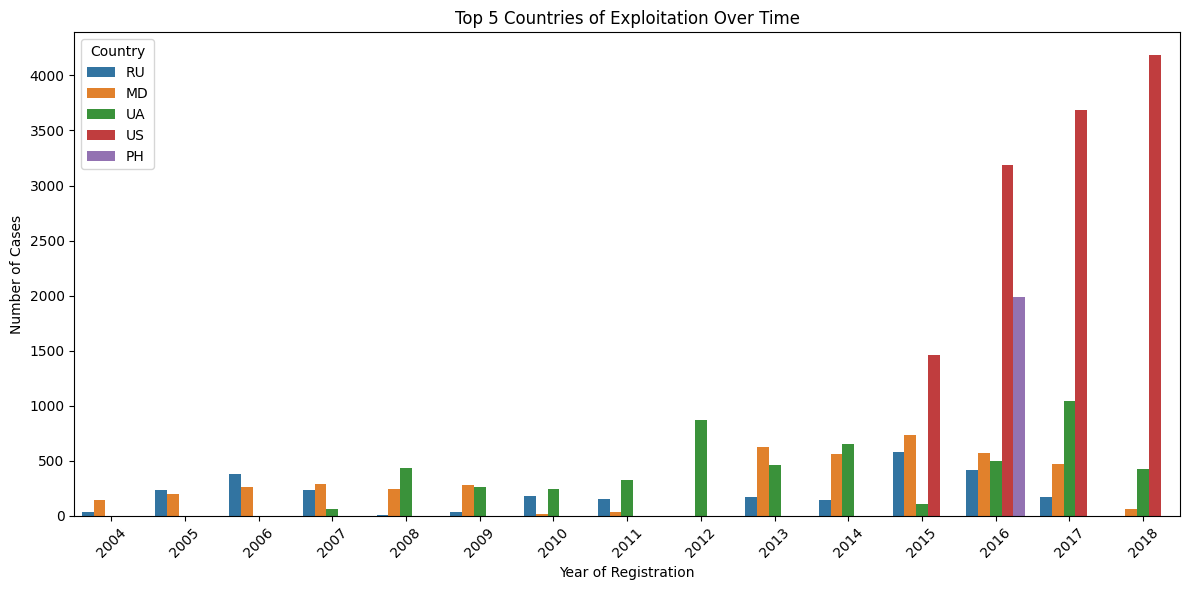

In [13]:
top_countries = df['CountryOfExploitation'].value_counts().head(5).index.tolist()

plt.figure(figsize=(12, 6))
sns.countplot(data=df[df['CountryOfExploitation'].isin(top_countries)], 
              x='yearOfRegistration', hue='CountryOfExploitation')
plt.title("Top 5 Countries of Exploitation Over Time")
plt.xlabel("Year of Registration")
plt.ylabel("Number of Cases")
plt.xticks(rotation=45)
plt.legend(title="Country")
plt.tight_layout()
plt.show()


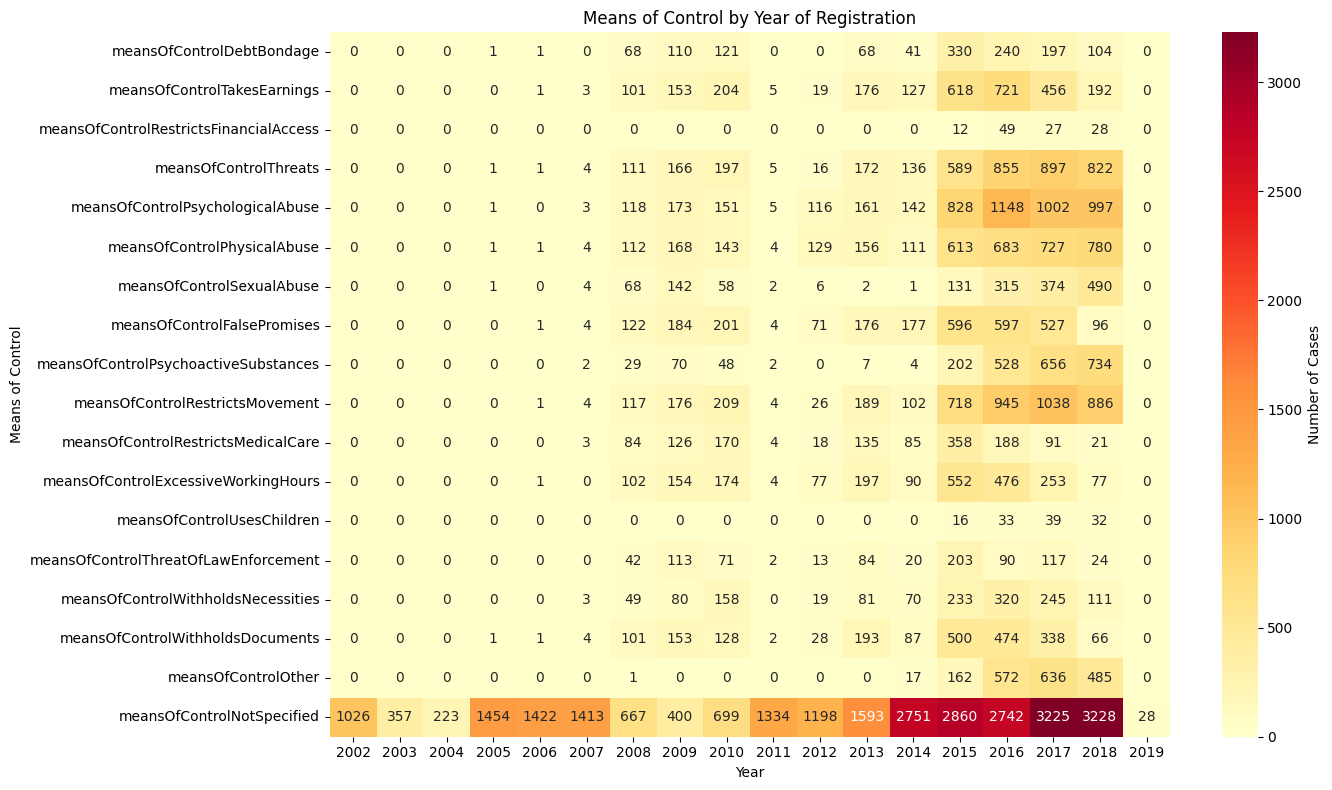

In [14]:
means_of_control_cols = [
    'meansOfControlDebtBondage',
    'meansOfControlTakesEarnings',
    'meansOfControlRestrictsFinancialAccess',
    'meansOfControlThreats',
    'meansOfControlPsychologicalAbuse',
    'meansOfControlPhysicalAbuse',
    'meansOfControlSexualAbuse',
    'meansOfControlFalsePromises',
    'meansOfControlPsychoactiveSubstances',
    'meansOfControlRestrictsMovement',
    'meansOfControlRestrictsMedicalCare',
    'meansOfControlExcessiveWorkingHours',
    'meansOfControlUsesChildren',
    'meansOfControlThreatOfLawEnforcement',
    'meansOfControlWithholdsNecessities',
    'meansOfControlWithholdsDocuments',
    'meansOfControlOther',
    'meansOfControlNotSpecified'
]

# Aggregate
yearly = df.groupby('yearOfRegistration')[means_of_control_cols].sum()

# Plot heatmap
plt.figure(figsize=(14, 8))
sns.heatmap(yearly.T, annot=True, fmt='g', cmap='YlOrRd', cbar_kws={'label': 'Number of Cases'})
plt.title('Means of Control by Year of Registration')
plt.xlabel('Year')
plt.ylabel('Means of Control')
plt.tight_layout()
plt.show()






##### more detailed code for means of control for each year of registration

In [15]:
# Aggregate
yearly = df.groupby('yearOfRegistration')[means_of_control_cols].sum().reset_index()

# Create traces for each control
fig = go.Figure()

for control in means_of_control_cols:
    fig.add_trace(
        go.Bar(x=yearly['yearOfRegistration'], y=yearly[control], name=control, visible=False)
    )

# Make first one visible
fig.data[0].visible = True

# Dropdown buttons
buttons = []
for i, control in enumerate(means_of_control_cols):
    visible = [False] * len(means_of_control_cols)
    visible[i] = True
    buttons.append(
        dict(label=control,
             method='update',
             args=[{'visible': visible},
                   {'title': f'Means of Control: {control}'}])
    )

# Layout
fig.update_layout(
    updatemenus=[dict(active=0, buttons=buttons, x=1.05)],
    title='Means of Control: ' + means_of_control_cols[0],
    xaxis_title='Year of Registration',
    yaxis_title='Number of Cases'
)

fig.show()



#### Datasource

In [16]:
df[['Datasource']].info()
df['Datasource'].value_counts()
df[['Datasource']].isnull().sum()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 48801 entries, 0 to 48800
Data columns (total 1 columns):
 #   Column      Non-Null Count  Dtype 
---  ------      --------------  ----- 
 0   Datasource  48801 non-null  object
dtypes: object(1)
memory usage: 381.4+ KB


Datasource    0
dtype: int64

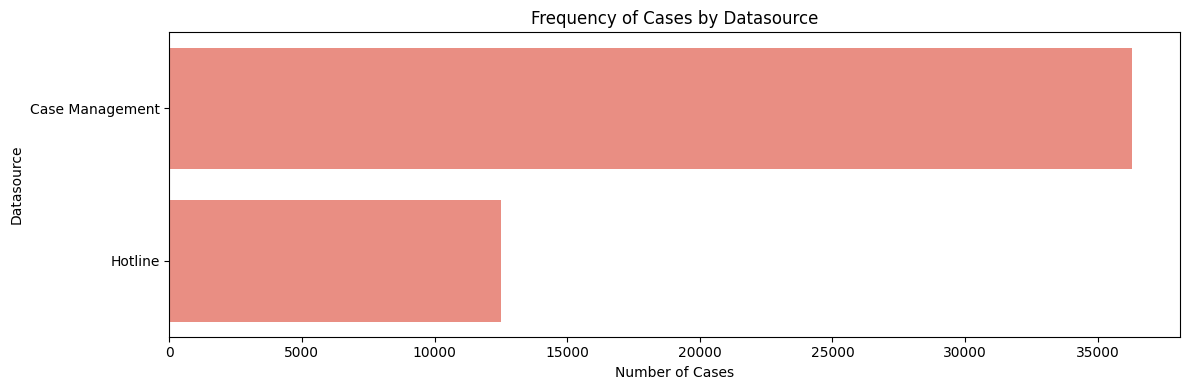

In [17]:
plt.figure(figsize=(12, 4))
sns.countplot(data=df, y='Datasource', order=df['Datasource'].value_counts().index, color='salmon')
plt.title("Frequency of Cases by Datasource")
plt.xlabel("Number of Cases")
plt.ylabel("Datasource")
plt.tight_layout()
plt.show()

### 2.1.1 Victim Demographics

### 2.1.2 Type of Exploitation

### 2.1.3 Type of Labour

### 2.1.4 Type of Sexual Exploitation

### 2.1.5 Types of Recuiter Relationship and Country of Exploitation

In [18]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import missingno as msno
import plotly.express as px
import plotly.graph_objects as go

# Optional: Set plotting style
sns.set(style="whitegrid")


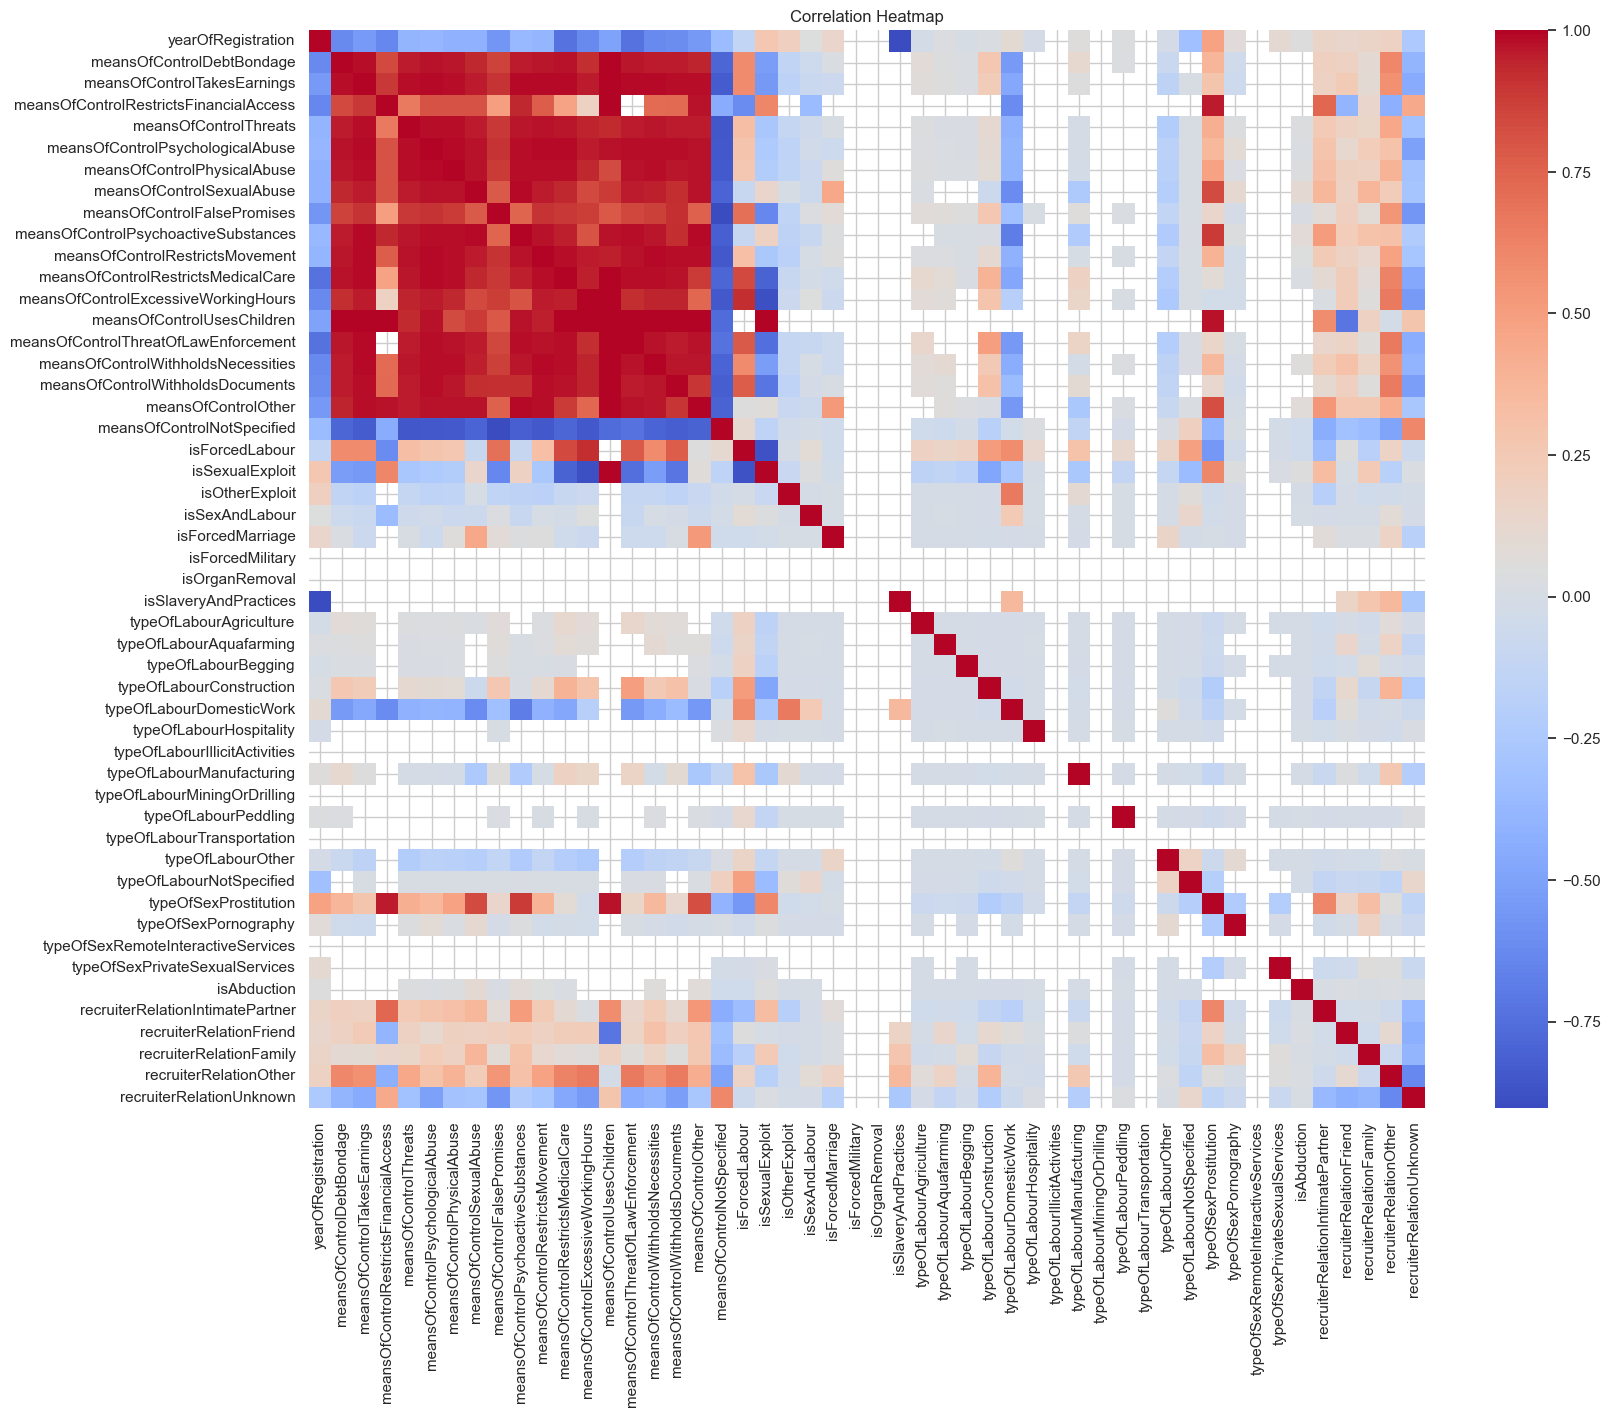

In [19]:
plt.figure(figsize=(18, 14))
sns.heatmap(df.corr(numeric_only=True), cmap='coolwarm', annot=False)
plt.title("Correlation Heatmap")
plt.show()


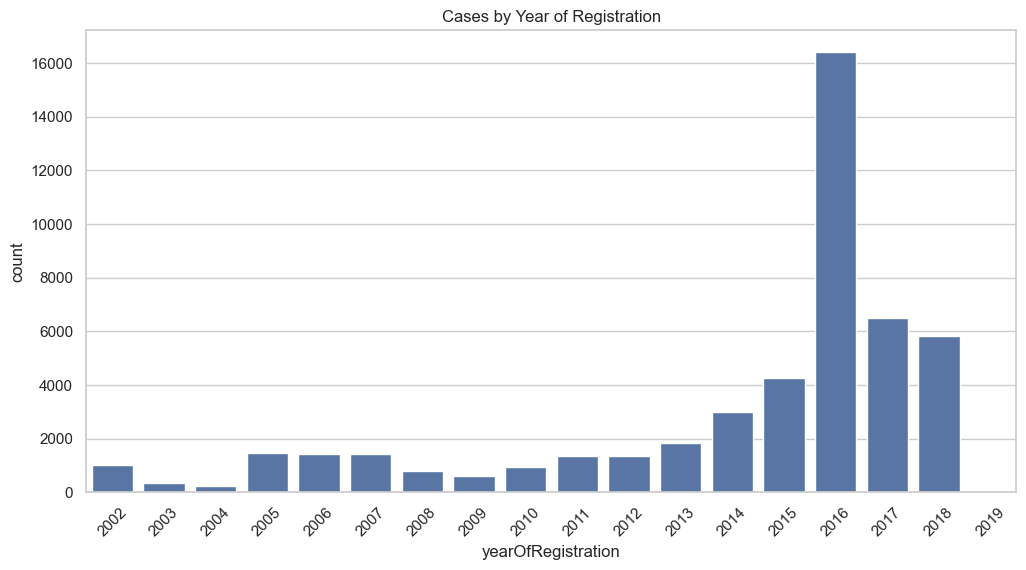

In [20]:
plt.figure(figsize=(12, 6))
sns.countplot(x='yearOfRegistration', data=df, order=sorted(df['yearOfRegistration'].dropna().unique()))
plt.xticks(rotation=45)
plt.title("Cases by Year of Registration")
plt.show()


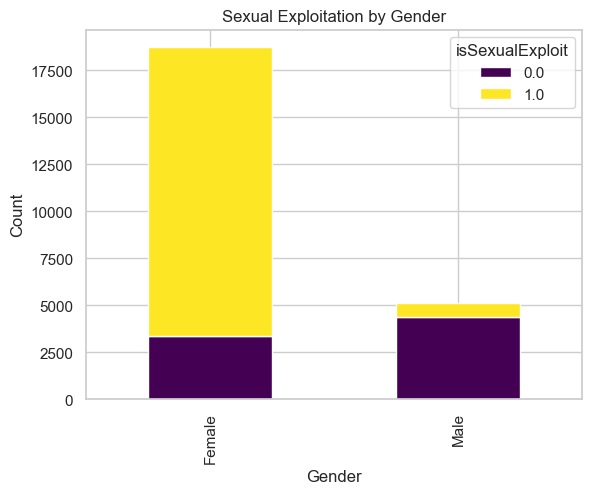

In [21]:
cross_tab = pd.crosstab(df['gender'], df['isSexualExploit'])
cross_tab.plot(kind='bar', stacked=True, colormap='viridis')
plt.title("Sexual Exploitation by Gender")
plt.ylabel("Count")
plt.xlabel("Gender")
plt.legend(title='isSexualExploit')
plt.show()


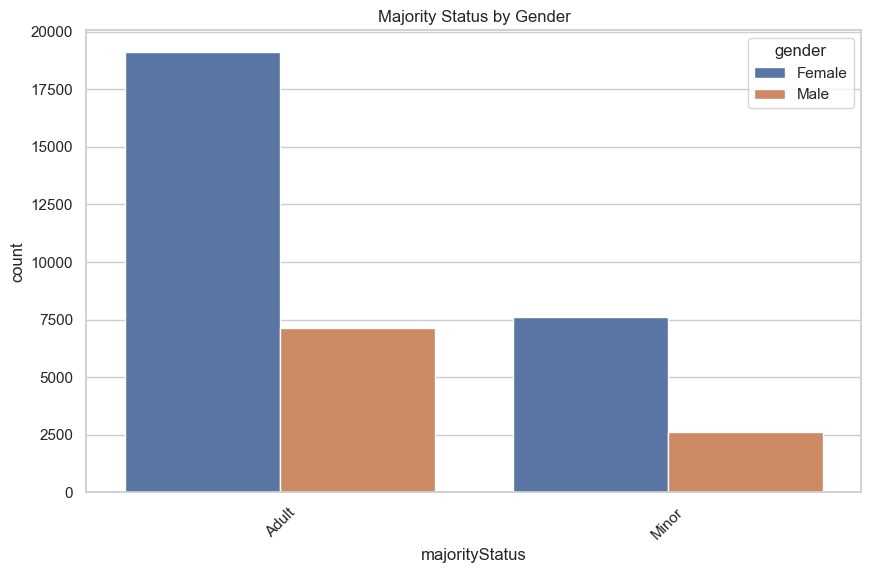

In [22]:
plt.figure(figsize=(10, 6))
sns.countplot(data=df, x='majorityStatus', hue='gender')
plt.title("Majority Status by Gender")
plt.xticks(rotation=45)
plt.show()


In [23]:
%pip install pycountry


Note: you may need to restart the kernel to use updated packages.


In [24]:
import pycountry
import plotly.express as px

# Create a mapping from ISO alpha-2 codes to full country names
def code_to_country(code):
    try:
        if pd.isna(code) or code == '00':
            return 'Unknown'
        return pycountry.countries.get(alpha_2=code).name
    except:
        return 'Unknown'

# Apply the mapping
df['citizenship_country'] = df['citizenship'].apply(code_to_country)

# Count occurrences
country_counts = df['citizenship_country'].value_counts().reset_index()
country_counts.columns = ['country', 'count']

# Plot the choropleth map
fig = px.choropleth(country_counts,
                    locations="country",
                    locationmode="country names",
                    color="count",
                    title="Cases by Citizenship Country",
                    color_continuous_scale=px.colors.sequential.Plasma)

fig.show()


In [25]:
country_counts = df['CountryOfExploitation'].value_counts().reset_index()
country_counts.columns = ['country', 'count']

fig = px.choropleth(country_counts,
                    locations="country",
                    locationmode="country names",
                    color="count",
                    title="Exploitation Cases by Country",
                    color_continuous_scale=px.colors.sequential.Plasma)

fig.show()


In [26]:
subset = df[['gender', 'typeOfExploitConcatenated', 'CountryOfExploitation']].dropna().copy()
subset = subset[subset['typeOfExploitConcatenated'] != '']

subset = subset.groupby(['gender', 'typeOfExploitConcatenated', 'CountryOfExploitation']).size().reset_index(name='count')

# Create node list
all_nodes = pd.concat([
    subset['gender'],
    subset['typeOfExploitConcatenated'],
    subset['CountryOfExploitation']
]).unique().tolist()

# Map node labels to index
label_to_idx = {label: idx for idx, label in enumerate(all_nodes)}

# Create links
source = subset['gender'].map(label_to_idx)
target = subset['typeOfExploitConcatenated'].map(label_to_idx)
middle_target = subset['CountryOfExploitation'].map(label_to_idx)

fig = go.Figure(data=[go.Sankey(
    node=dict(
        pad=15,
        thickness=20,
        line=dict(color="black", width=0.5),
        label=all_nodes
    ),
    link=dict(
        source=source,
        target=target,
        value=subset['count']
    )
)])

fig.update_layout(title_text="Sankey Diagram: Gender → Type of Exploitation", font_size=10)
fig.show()


# 3. Handling Missing Values

# 4. Outliers

# 5. Data Partitioning (Split)

In [27]:
from sklearn.model_selection import train_test_split

X_train, X_test = train_test_split(df, test_size=0.2, random_state=42)

# 6. Feature Engineering and Scaling

# 7. Model Selection

## 7.1 Baseline Model

## 7.2 Model 1

## 7.3 Model 2

# 8. Model Evaluation